In [1]:
pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 4.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630162 sha256=87d005771c91748c851b97273f45eb23fa6077dcc8540e3f9154799d135b2e59
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import pandas as pd 
import numpy as np
import math
import re 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate


## data loading


In [3]:
cb1_path ='/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_1.txt'
# cb2_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_2.txt'
# cb3_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_3.txt'
# cb4_path ='/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/combined_data_4.txt'

In [4]:
# usecols : 사용할 컬럼
df1 =  pd.read_csv(cb1_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df2 =  pd.read_csv(cb2_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df3 =  pd.read_csv(cb3_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df4 =  pd.read_csv(cb4_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

In [5]:
df1 = df1.iloc[0:10000]

In [6]:
print(df1.dtypes)
print("=======")


Cust_Id     object
Rating     float64
dtype: object


In [7]:
# 'Rating' 컬럼의 데이터 속성을 실수형으로 변환
df1['Rating'] = df1['Rating'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
print('Dataset 1 shape : {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape : (10000, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


In [9]:
df = df1
# df = df1.append(df2)
# df = df.append(df3)
# df = df.append(df4)

In [10]:
np.arange(0,len(df))

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [11]:
df.index

RangeIndex(start=0, stop=10000, step=1)

In [12]:
# 4개의 데이터셋을 합쳐서, 인덱스 초기화를 하려는 의도같음
# reset_index를 썻어도 무관했을듯하다.
df.index = np.arange(0,len(df))

## data viewing

In [13]:
# 1 내가 작성한 코드
# 2번과 동일하니 편한것 사용하면 될것 같음
# Rating 기준으로 Cust_id의 수를 파악
df.groupby(df['Rating']).count()

,Cust_Id
Rating,
1.0,1166
2.0,1260
3.0,2450
4.0,2926
5.0,2190


In [14]:
# 2 작성자의 코드
# groupby(기준이되는 열)
p = df.groupby('Rating')['Rating'].agg(['count'])

In [15]:
p

,count
Rating,
1.0,1166
2.0,1260
3.0,2450
4.0,2926
5.0,2190


In [16]:
# 널값 구함
print(df.isnull().sum())
print(df.isnull().sum()[1])

Cust_Id    0
Rating     8
dtype: int64
8


In [17]:
movie_count = df.isnull().sum()[1]

In [18]:
# nunique : 데이터에 고유값들의 수를 출력
df['Cust_Id'].nunique()

9627

In [19]:
df['Cust_Id'].count()

10000

In [20]:
# cust_count = 고유값 수에서 널값 제거
cust_count = df['Cust_Id'].nunique() - movie_count

# 널값이 없는 행 개수
rating_count = df['Cust_Id'].count() - movie_count

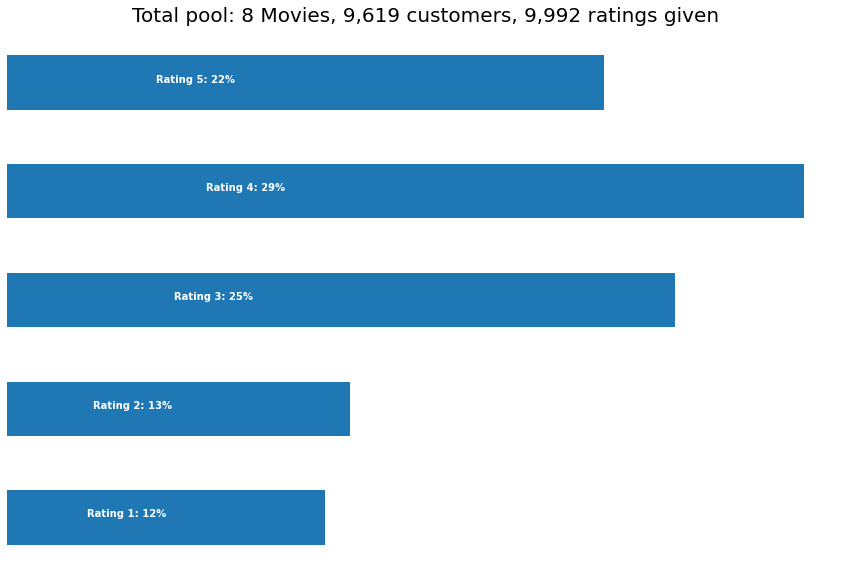

In [21]:
ax = p.plot(kind = 'barh', legend = False, figsize = (15, 10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## data cleansing

In [22]:
df.Rating

0       NaN
1       3.0
2       5.0
3       4.0
4       4.0
       ... 
9995    1.0
9996    3.0
9997    4.0
9998    3.0
9999    1.0
Name: Rating, Length: 10000, dtype: float64

In [23]:
# dataframe에 null값 확인
pd.isnull(df.Rating)

0        True
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: Rating, Length: 10000, dtype: bool

In [24]:

pd.DataFrame(pd.isnull(df.Rating))

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
9995,False
9996,False
9997,False
9998,False


In [25]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))

In [26]:
df_nan

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
9995,False
9996,False
9997,False
9998,False


In [27]:
# nan인것만으로 데이터 프레임 만들기
df_nan[df_nan['Rating'] == True]

,Rating
0,True
548,True
694,True
2707,True
2850,True
3991,True
5011,True
5105,True


In [28]:
df_nan = df_nan[df_nan['Rating'] == True]

In [29]:
# 인덱스 초기화
df_nan = df_nan.reset_index()

In [30]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
5,3991,True
6,5011,True
7,5105,True


In [31]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
5,3991,True
6,5011,True
7,5105,True


In [32]:
np.full((1,10), 2)

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [33]:
movie_np = []
movie_id = 1
# np.full((1,10), 2) : 1 부터 10 총 10개를 2로 채운다
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    print(i)
    print(j)
    
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    print(temp)
    print(len(temp[0]))
    print("===")
    movie_np = np.append(movie_np, temp)
    movie_id += 1

548
0
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [34]:
movie_np

array([1., 1., 1., ..., 7., 7., 7.])

In [35]:
len(movie_np)

5098

In [38]:
len(last_record[0])

4894

In [39]:
df_nan.iloc[-1, 0]

5105

In [37]:
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1. 1. 1. ... 8. 8. 8.]
Length: 9992


In [40]:
df['Rating']

0       NaN
1       3.0
2       5.0
3       4.0
4       4.0
       ... 
9995    1.0
9996    3.0
9997    4.0
9998    3.0
9999    1.0
Name: Rating, Length: 10000, dtype: float64

In [41]:
df[pd.notnull(df['Rating'])]

,Cust_Id,Rating
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
...,...,...
9995,2142408,1.0
9996,2231367,3.0
9997,1304395,4.0
9998,1468830,3.0


In [42]:
# remove those Movie ID rows

# null빼고 df 다시 만들기
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
   Cust_Id  Rating  Movie_Id
1  1488844     3.0         1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [43]:
# 영화 ID를 만드는 기준이 널과 널사이 인데 데이터 설명을 읽어봐야할거같다
df

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
9995,2142408,1.0,8
9996,2231367,3.0,8
9997,1304395,4.0,8
9998,1468830,3.0,8


# data slicing

In [48]:
df.groupby('Movie_Id')[['Rating']].mean()

,Rating
Movie_Id,
1,3.749543
2,3.558621
3,3.641153
4,2.739437
5,3.919298
6,3.084396
7,2.129032
8,3.187372


In [44]:
f = ['count','mean']

# 여기서 agg메서드의 장점이 나온것같다. 
# 여러개의 함수를 같이 사용 가능
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary

,count,mean
Movie_Id,,
1,547,3.749543
2,145,3.558621
3,2012,3.641153
4,142,2.739437
5,1140,3.919298
6,1019,3.084396
7,93,2.129032
8,4894,3.187372


In [49]:
df_movie_summary.index.map(int)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='Movie_Id')

In [51]:
df_movie_summary.index = df_movie_summary.index.map(int)

In [53]:
# count의 0.7 분위수를 구함, 
# round함수를 사용해서 소수점 0번쨰까지 표시
round(df_movie_summary['count'].quantile(0.7),0)

1128.0

In [52]:
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)

In [55]:
df_movie_summary['count'] < movie_benchmark

Movie_Id
1     True
2     True
3    False
4     True
5    False
6     True
7     True
8    False
Name: count, dtype: bool

In [54]:
# 총합이 0.7분위수보다 작은것들만 뽑아서 df만듬
df_movie_summary[df_movie_summary['count'] < movie_benchmark]

,count,mean
Movie_Id,,
1,547,3.749543
2,145,3.558621
4,142,2.739437
6,1019,3.084396
7,93,2.129032


In [56]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)

# 인덱스를 int형태로 매핑, 굳이 하지않아도 int형으로 매핑이 된다.
df_movie_summary.index = df_movie_summary.index.map(int)


movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)

# 총합이 0.7분위수보다 작은것들의 인덱스를 구해서 drop_movie_list를 만듬
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1128.0


In [62]:
drop_movie_list

Int64Index([1, 2, 4, 6, 7], dtype='int64', name='Movie_Id')

In [57]:
# CUst_Id 컬럼도 무비아이디랑 똑같ㅇ ㅣ진행
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Customer minimum times of review: 1.0


In [58]:
# ~ 를 사용해서 not을 사용한다는게 신기
# 즉 drop_movie_list안에 없는것들의 데이터프레임
df[~df['Movie_Id'].isin(drop_movie_list)]

,Cust_Id,Rating,Movie_Id
695,1025579,4.0,3
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
...,...,...,...
9995,2142408,1.0,8
9996,2231367,3.0,8
9997,1304395,4.0,8
9998,1468830,3.0,8


In [63]:
print('Original Shape: {}'.format(df.shape))

# ~ 를 사용해서 not을 사용한다는게 신기
# 즉 drop_movie_list안에 없는것들의 데이터프레임
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (9992, 3)
After Trim Shape: (8046, 3)
-Data Examples-
     Cust_Id  Rating  Movie_Id
695  1025579     4.0         3


In [64]:
# index  = 행위치에 들어갈 값
# columns = 열 위치에 들어갈 값
# values =  데이터로 사용할 열
# agg도 들어가는데 디폴트값은 'mean'
pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

Movie_Id,3,5,8
Cust_Id,,,
685,NaN,3.0,NaN
695,NaN,NaN,1.0
1333,4.0,NaN,3.0
2133,NaN,NaN,2.0
3292,NaN,NaN,4.0
...,...,...,...
2647626,NaN,NaN,4.0
2647871,NaN,5.0,NaN
2648122,NaN,4.0,NaN


In [65]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(7922, 3)


In [66]:
title_path = '/content/drive/MyDrive/Colab Notebooks/넷플릭스 영화추천/movie_titles.csv'

In [67]:
df_title = pd.read_csv(title_path, encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# recommend with CF

In [70]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'fit_time': (0.4005286693572998,
  0.40883684158325195,
  0.419785737991333,
  0.4154820442199707,
  0.41512441635131836),
 'test_mae': array([1.01575197, 1.02933552, 1.00219463, 0.98645766, 1.00333945]),
 'test_rmse': array([1.25780579, 1.26306198, 1.23997472, 1.223159  , 1.21787725]),
 'test_time': (0.010724067687988281,
  0.012394905090332031,
  0.011821985244750977,
  0.010730504989624023,
  0.010599613189697266)}

In [69]:
 df[df['Cust_Id'] == 785314]

,Cust_Id,Rating,Movie_Id
5109,785314,1.0,8


In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Series([], Name: Name, dtype: object)


In [ ]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

         Year                                     Name  Estimate_Score
4      2004.0                 The Rise and Fall of ECW        3.876359
2      1997.0                                Character        3.673474
17768  2003.0                              The Company        3.233299
11845  1985.0                           Prizzi's Honor        3.233299
11851  1991.0                Return to the Blue Lagoon        3.233299
11850  1946.0                             The Yearling        3.233299
11849  2003.0  Dumb and Dumberer: When Harry Met Lloyd        3.233299
11848  1998.0                                    Earth        3.233299
11847  1997.0                     For Richer or Poorer        3.233299
11846  2005.0                            Dust to Glory        3.233299


In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                       Name  count     mean
 1.000000 What the #$*! Do We Know!?   4894 3.187372
 0.289046                  Character   2012 3.641153
 0.161880   The Rise and Fall of ECW   1140 3.919298
